# SCNIEC+

This notebook runs the SCENIC+ framework for unpaired scRNA-seq and scATAC-seq on the tumor cells from the Spermatogenesis Mouse dataset 

In [1]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
sys.path.append('/home/sussmanj/miniconda3/envs/scenicplus/lib/')
_stderr = sys.stderr
null = open(os.devnull,'wb')

%matplotlib inline

In [2]:
import importlib
import sys
import os 
import scanpy as sc
from scipy.io import mmread
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from scenicplus.scenicplus_class import SCENICPLUS, create_SCENICPLUS_object
from scenicplus.loom import *
from scenicplus.preprocessing.filtering import *
from pycisTopic.cistopic_class import *
from pycisTopic.lda_models import evaluate_models
from pycisTopic.clust_vis import run_umap
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
import pickle
import dill
from pycisTopic.clust_vis import *
from pycisTopic.topic_binarization import *
from pycisTopic.diff_features import *
from pycisTopic.lda_models import run_cgs_models_mallet
import scipy.sparse as sp
import scipy.io as spio
import pyranges as pr
import numpy as  np
from pycistarget.utils import region_names_to_coordinates
from pycisTopic.lda_models import run_cgs_models
from scenicplus.wrappers.run_pycistarget import run_pycistarget
import pybiomart as pbm
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
from scenicplus.eregulon_enrichment import score_eRegulons
import seaborn as sns
from scenicplus.plotting.dotplot import heatmap_dotplot
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
from scenicplus.RSS import *
from scenicplus.plotting.correlation_plot import *
from pycisTopic.diff_features import find_highly_variable_features
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
import seaborn as sns
import sklearn
from scenicplus.differentiation_potential import *

/home/sussmanj/miniconda3/envs/ScenicPlus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-06 14:33:21,510	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Generate cisTopic object from ATAC counts matrix and save to file 

In [4]:
#Create cisTopic object from the counts matrix 
sparse_csr_matrix=spio.mmread('/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/ATAC_Peaks_Sparse.mtx').tocsr()
cell_list = []
region_list = [] 

with open("/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/ATAC_Cell_Names.txt", "r") as file:
    cell_list = [line.strip() for line in file]
with open("/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/ATAC_Region_Names.txt", "r") as file:
    region_list = [line.strip() for line in file]
region_list = [s.replace('-', ':', 1) for s in region_list]

path_to_blacklist='/mnt/isilon/tan_lab/sussmanj/Single_Cell_Tools/ScenicPlus/Genome_Files/hg38-blacklist.v2.bed'

In [5]:
cistopic_obj = create_cistopic_object(fragment_matrix=sparse_csr_matrix, cell_names=cell_list, region_names=region_list,
                                      path_to_blacklist=path_to_blacklist)

2024-04-20 22:22:12,479 cisTopic     INFO     Removing blacklisted regions
2024-04-20 22:22:13,532 cisTopic     INFO     Creating CistopicObject
2024-04-20 22:22:16,111 cisTopic     INFO     Done!


In [6]:
#Add cell metadata
cell_data =  pd.read_csv('/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/ATAC_Metadata.txt', sep='\t')
cell_data.index = cell_list
cistopic_obj.add_cell_data(cell_data)

In [7]:
#Save cisTopic object
pickle.dump(cistopic_obj, open('/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/ATAC_cistopic_obj.pkl', 'wb'))

In [8]:
#Check the cisTopic object
print(cistopic_obj)

CistopicObject from project cisTopic with n_cells × n_regions = 12908 × 199344


Load in the cisTopic object and perform topic modeling

In [3]:
#Load cisTopic object
cistopic_obj = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/ATAC_cistopic_obj.pkl', 'rb'))
print(cistopic_obj)

CistopicObject from project cisTopic with n_cells × n_regions = 12908 × 199344


In [ ]:
if not os.path.exists(os.path.join('/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/', 'Tmp_Files')):
    os.makedirs(os.path.join('/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/', 'Tmp_Files'))  
    
os.environ['MALLET_MEMORY'] = '700G'
mallet_path = "/mnt/isilon/tan_lab/sussmanj/Single_Cell_Tools/ScenicPlus/Mallet-202108/bin/mallet"
models=run_cgs_models_mallet(cistopic_obj,
                    mallet_path = mallet_path, 
                    n_topics=[2,5,10,15,20,25,30,35,40,45,50],
                    n_cpu=72,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path = '/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Tmp_Files',
                    tmp_path = '/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Tmp_Files')
pickle.dump(models, open('/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/ATAC_Models_500_iter_LDA.pkl', 'wb'))

2024-04-20 22:23:20,163 cisTopic     INFO     Formatting input to corpus
2024-04-20 22:23:22,460 cisTopic     INFO     Running model with 2 topics
2024-04-20 22:23:22,461 LDAMalletWrapper INFO     Serializing temporary corpus to /mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Tmp_Files/corpus.txt
2024-04-20 22:24:07,187 LDAMalletWrapper INFO     Converting temporary corpus to MALLET format with: /mnt/isilon/tan_lab/sussmanj/Single_Cell_Tools/ScenicPlus/Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --token-regex \S+ --input /mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Tmp_Files/corpus.txt --output /mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Tmp_Files/corpus.mallet
2024-04-20 22:24:39,203 LDAMalletWrapper INFO     Training MALLET LDA with: /mnt/isilon/tan_lab/sussmanj/Single_Cell_Tools/ScenicPlus/Mallet-202108/bin/mallet train-topics --input /mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Tmp_Files/corpus.mallet --num-topics 2 --alpha 50 

2024-04-20 23:43:19,602 LDAMalletWrapper INFO     loading assigned topics from /mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Tmp_Files/b9e945_state.mallet.gz
2024-04-20 23:43:38,957 cisTopic     INFO     Model with 20 topics done!
2024-04-20 23:43:38,957 cisTopic     INFO     Saving model with 20 topics at /mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Tmp_Files
2024-04-20 23:43:39,187 cisTopic     INFO     Running model with 25 topics
2024-04-20 23:43:39,188 LDAMalletWrapper INFO     Serializing temporary corpus to /mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Tmp_Files/corpus.txt
2024-04-20 23:44:24,124 LDAMalletWrapper INFO     Converting temporary corpus to MALLET format with: /mnt/isilon/tan_lab/sussmanj/Single_Cell_Tools/ScenicPlus/Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --token-regex \S+ --input /mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Tmp_Files/corpus.txt --output /mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/T

In [4]:
#Load models 
models = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/ATAC_Models_500_iter_LDA.pkl', 'rb'))

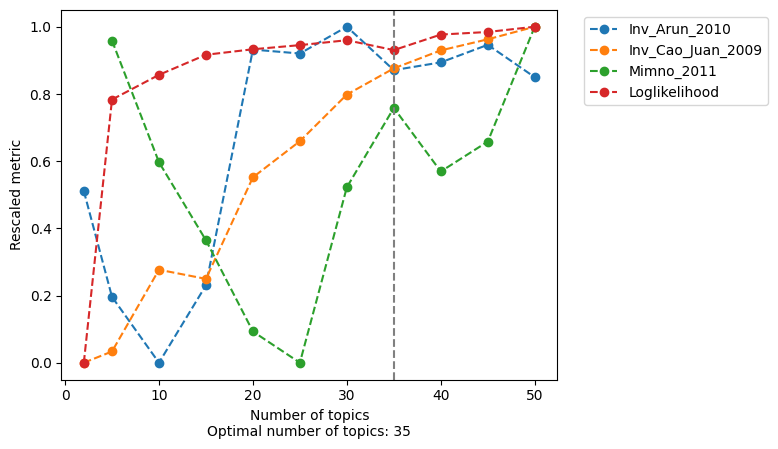

In [6]:
numTopics = 35
model = evaluate_models(models,
                     select_model = numTopics,
                     return_model = True,
                     metrics = ['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics = False)

In [8]:
#Add model to cisTopic object and save again 
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open('/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/ATAC_cistopic_obj_with_model.pkl', 'wb'))

In [9]:
#Run UMAP
run_umap(cistopic_obj, target = 'cell', scale = True)

2024-04-21 09:55:36,636 cisTopic     INFO     Running UMAP


/home/sussmanj/miniconda3/envs/ScenicPlus/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


Visualization

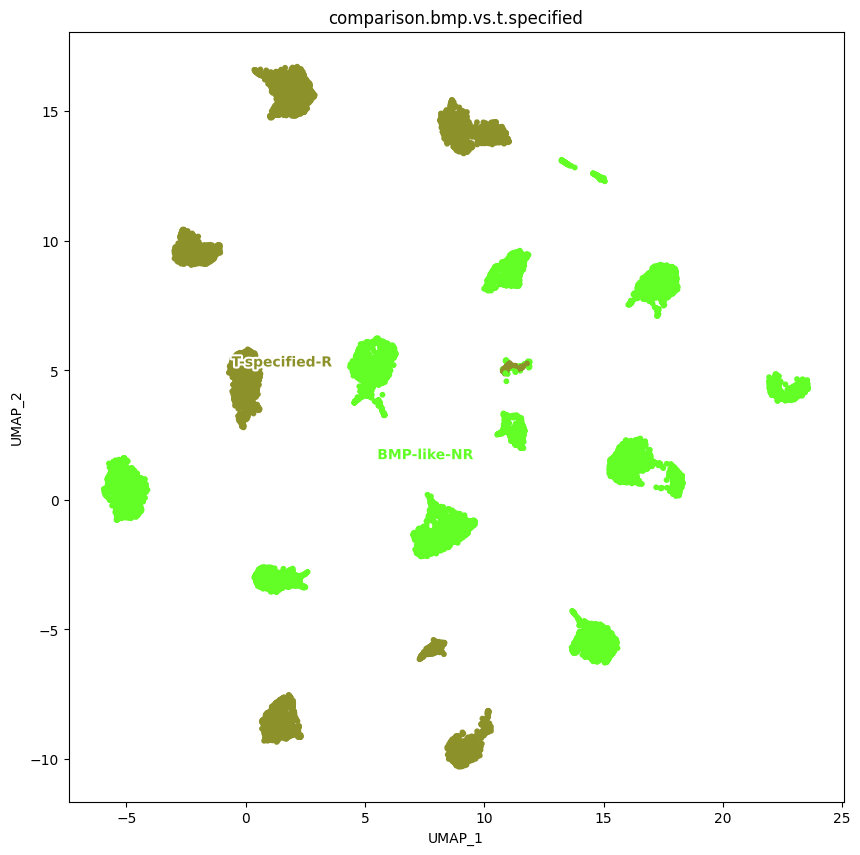

2024-04-21 09:56:01,876 fontTools.subset INFO     maxp pruned
2024-04-21 09:56:01,887 fontTools.subset INFO     cmap pruned
2024-04-21 09:56:01,894 fontTools.subset INFO     kern dropped
2024-04-21 09:56:01,895 fontTools.subset INFO     post pruned
2024-04-21 09:56:01,896 fontTools.subset INFO     FFTM dropped
2024-04-21 09:56:01,899 fontTools.subset INFO     GPOS pruned
2024-04-21 09:56:01,902 fontTools.subset INFO     GSUB pruned
2024-04-21 09:56:01,907 fontTools.subset INFO     glyf pruned
2024-04-21 09:56:01,908 fontTools.subset INFO     Added gid0 to subset
2024-04-21 09:56:01,908 fontTools.subset INFO     Added first four glyphs to subset
2024-04-21 09:56:01,909 fontTools.subset INFO     Closing glyph list over 'GSUB': 30 glyphs before
2024-04-21 09:56:01,909 fontTools.subset INFO     Glyph names: ['.notdef', '.null', 'A', 'M', 'P', 'U', 'a', 'b', 'c', 'd', 'e', 'f', 'five', 'i', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'two', 'und

In [10]:
plot_metadata(
    cistopic_obj,
    reduction_name = 'UMAP',
    variables = ['comparison.bmp.vs.t.specified'],
    figsize = (10, 10), 
    save = "/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/UMAP_CisTopics.jpg")

In [ ]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 5, 
           save = "/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/FeaturePlot_CisTopics.png")

Inferring candidate enhancer regions

In [30]:
#Load cisTopic object
cistopic_obj = pickle.load(open('/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/ATAC_cistopic_obj_with_model.pkl', 'rb'))
print(cistopic_obj)

CistopicObject from project cisTopic with n_cells × n_regions = 30478 × 302363


In [12]:
#Binarize topics, using the 'otsu' method
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
#Calculating DARs per cell type 
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='comparison.bmp.vs.t.specified', var_features=variable_regions, split_pattern = '-')

2024-04-21 09:57:40,652 cisTopic     INFO     Imputing region accessibility
2024-04-21 09:57:40,653 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-04-21 09:58:26,852 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-04-21 09:58:30,740 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-04-21 09:58:32,723 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-04-21 09:58:35,339 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2024-04-21 09:58:38,852 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2024-04-21 09:58:42,944 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2024-04-21 09:58:47,521 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2024-04-21 09:58:56,754 cisTopic     INFO     Impute region accessibility for regions 160000-180000
2024-04-21 09:59:06,493 cisTopic     

<Figure size 640x480 with 0 Axes>

In [14]:
#Save results 
pickle.dump(region_bin_topics_otsu, open('/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/region_bin_topics_otsu.pkl', 'wb'))
pickle.dump(region_bin_topics_top3k, open('/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/region_bin_topics_top3k.pkl', 'wb'))

In [15]:
out_dir = "/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus"
os.makedirs(os.path.join("/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus", "region_sets"), exist_ok = True)
os.makedirs(os.path.join("/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus", "region_sets", "Topics_otsu"), exist_ok = True)
os.makedirs(os.path.join("/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus", "region_sets", "Topics_top_3k"), exist_ok = True)
os.makedirs(os.path.join("/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus", "region_sets", "DARs_cell_type"), exist_ok = True)

In [16]:
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "Topics_otsu", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [17]:
for topic in region_bin_topics_top3k:
    region_names_to_coordinates(
        region_bin_topics_top3k[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "Topics_top_3k", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [18]:
for cell_type in markers_dict:
    region_names_to_coordinates(
        markers_dict[cell_type].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "DARs_cell_type", f"{cell_type}.bed"),
        sep = "\t",
        header = False, index = False
    )

Save RNA to anndata format 

In [19]:
#Load RNA data
path_to_loom = '/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/TALL_BMP_TSpec_RNA.loom'
rna_anndata = sc.read_loom(path_to_loom)
rna_anndata.raw = rna_anndata
rna_anndata.write("/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/TALL_BMP_TSpec_RNA.h5ad")

In [3]:
#Load RNA data
path_to_loom = '/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/TALL_ETP_Subtype_RNA.loom'
rna_anndata = sc.read_loom(path_to_loom)
rna_anndata.raw = rna_anndata
rna_anndata.write("/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/Data_SCENICplus/TALL_ETP_Subtype_RNA.h5ad")

... storing 'D29.BM' as categorical
... storing 'Doublet_Singlet' as categorical
... storing 'ETP' as categorical
... storing 'Phase' as categorical
... storing 'RNA_snn_res.0.4' as categorical
... storing 'RNA_snn_res.0.8' as categorical
... storing 'RNA_snn_res.1' as categorical
... storing 'RNA_snn_res.1.2' as categorical
... storing 'RNA_snn_res.1.6' as categorical
... storing 'RNA_snn_res.2' as categorical
... storing 'RNA_snn_res.2.5' as categorical
... storing 'RNA_snn_res.3' as categorical
... storing 'blast.healthy' as categorical
... storing 'event' as categorical
... storing 'gender' as categorical
... storing 'is.blast.viscello' as categorical
... storing 'level.1.anno.viscello' as categorical
... storing 'level.1.anno.viscello.sample.group.short' as categorical
... storing 'old.ident' as categorical
... storing 'orig.ident' as categorical
... storing 'predicted.cell.type.binned' as categorical
... storing 'predicted.cell.type.short' as categorical
... storing 'predicted.id

In [4]:
rna_anndata

AnnData object with n_obs × n_vars = 44531 × 33538
    obs: 'D29.BM', 'D29.MRD', 'Doublet_Singlet', 'ETP', 'G2M.Score', 'HeatShock.Score1', 'Phase', 'RNA_snn_res.0.4', 'RNA_snn_res.0.4_entropy', 'RNA_snn_res.0.8', 'RNA_snn_res.0.8_entropy', 'RNA_snn_res.1', 'RNA_snn_res.1.2', 'RNA_snn_res.1.2_entropy', 'RNA_snn_res.1.6', 'RNA_snn_res.1.6_entropy', 'RNA_snn_res.2', 'RNA_snn_res.2.5', 'RNA_snn_res.2.5_entropy', 'RNA_snn_res.2_entropy', 'RNA_snn_res.3', 'RNA_snn_res.3_entropy', 'S.Score', 'blast.healthy', 'cell.name', 'event', 'gender', 'is.blast.viscello', 'level.1.anno.viscello', 'level.1.anno.viscello.sample.group.short', 'nCount_ADT', 'nCount_RNA', 'nFeature_ADT', 'nFeature_RNA', 'old.ident', 'orig.ident', 'perc.mito', 'predicted.cell.type.binned', 'predicted.cell.type.binned.score', 'predicted.cell.type.short', 'predicted.cell.type.short.score', 'predicted.id_5_14_21', 'predicted.m.traj.ptime', 'predicted.m.traj.ptime.score', 'predicted.t.traj.ptime', 'predicted.t.traj.ptime.score', 